In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.weightstats as ws

In [2]:
df = pd.read_csv('TRAIN.csv')

In [3]:
df.Date=pd.to_datetime(df.Date,format ="%Y-%m-%d")
df.Discount=df.Discount.map(lambda x: 1 if x=='Yes' else 0)
df['discount_and_holiday']=(df.Discount & df.Holiday)
df['discount_or_holiday']= (df.Discount | df.Holiday)
df=df.drop(columns=['ID','Store_id'])

# --- Exploratory Data Analysis (EDA) ---

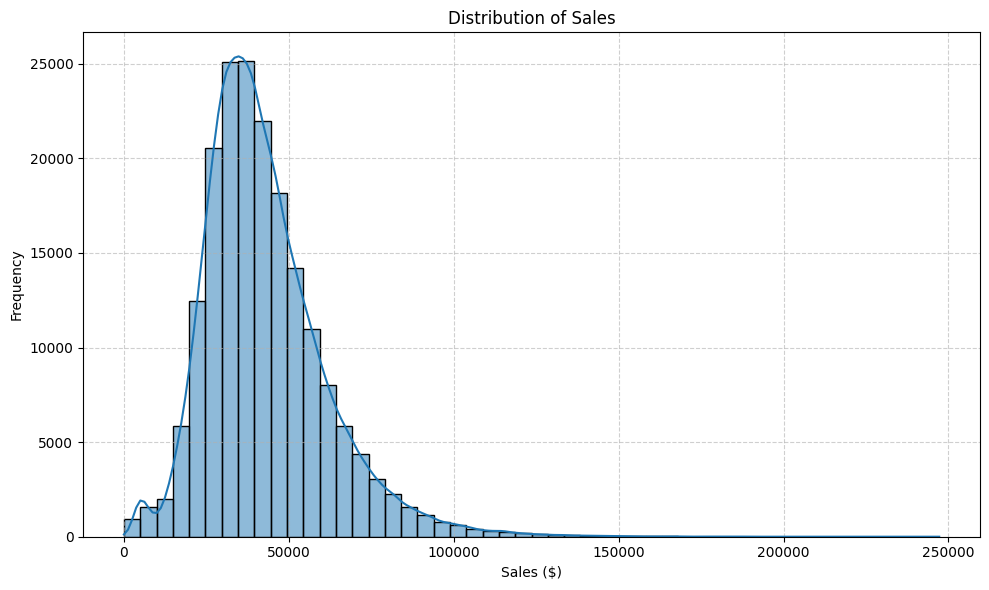

In [4]:
# 1. Sales Distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales ($)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

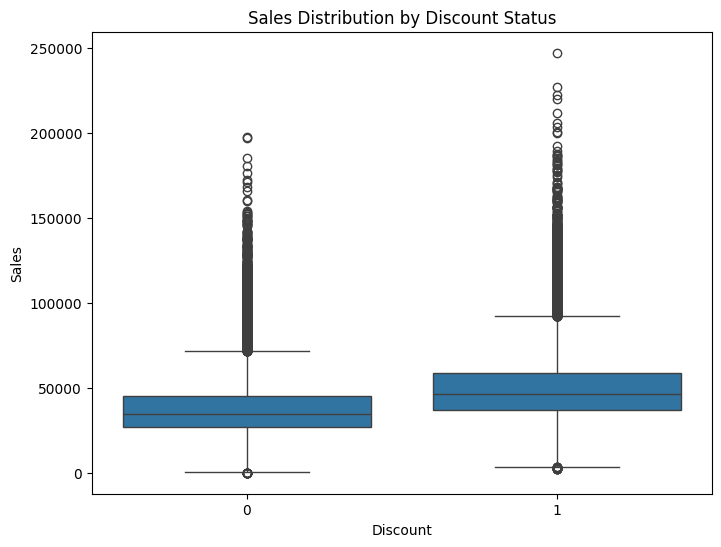

In [5]:
# 2. Sales by Discount (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Discount', y='Sales', data=df)
plt.title('Sales Distribution by Discount Status')
plt.show()

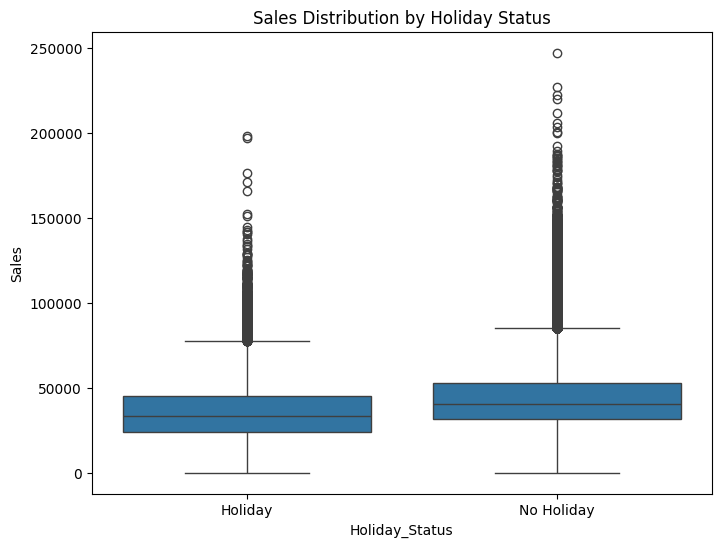

In [6]:
# 3. Sales by Holiday (Box Plot)
df['Holiday_Status'] = df['Holiday'].map({0: 'No Holiday', 1: 'Holiday'})
plt.figure(figsize=(8, 6))
sns.boxplot(x='Holiday_Status', y='Sales', data=df)
plt.title('Sales Distribution by Holiday Status')
plt.show()

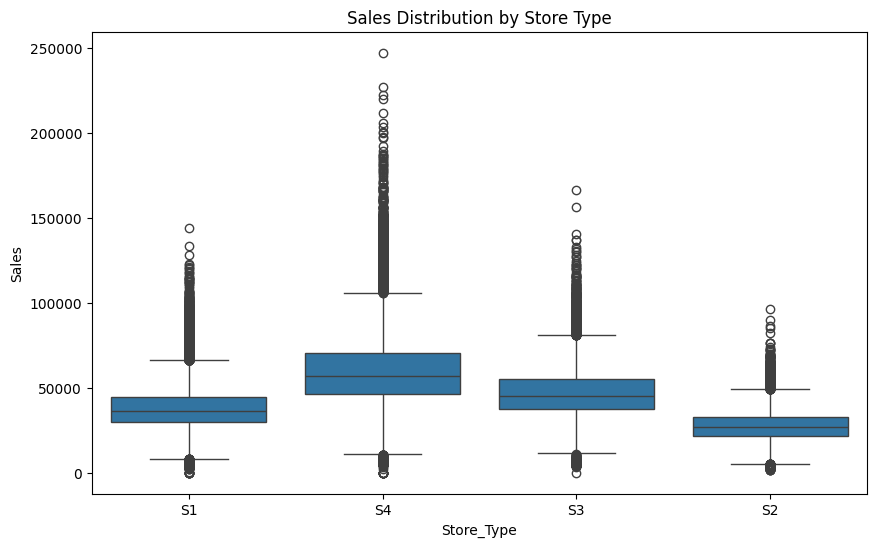

In [7]:
# 4. Sales by Store Type (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Store_Type', y='Sales', data=df)
plt.title('Sales Distribution by Store Type')
plt.show()

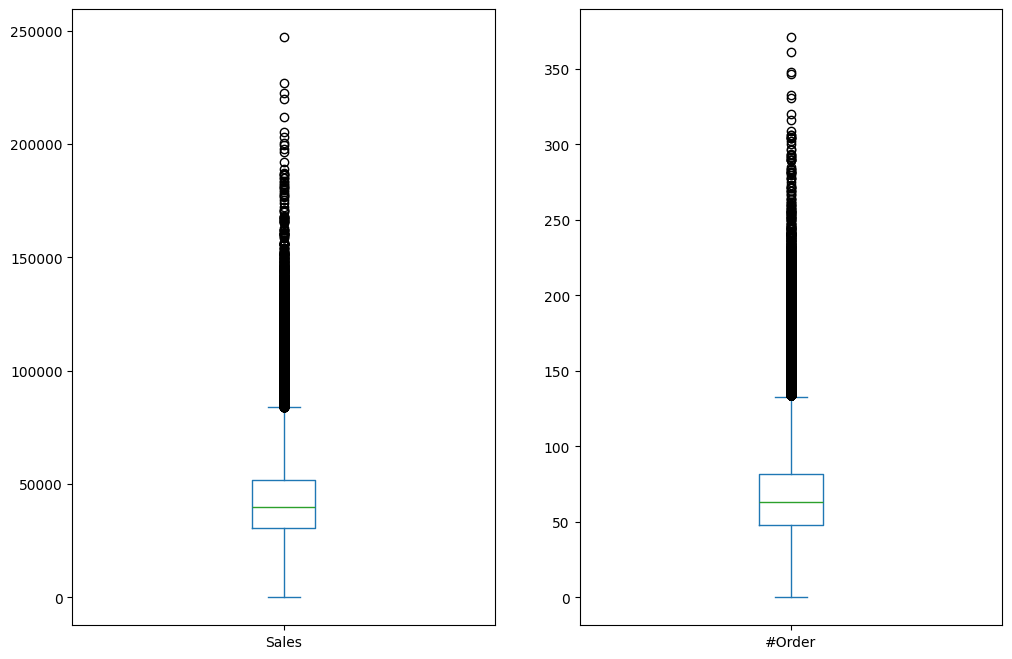

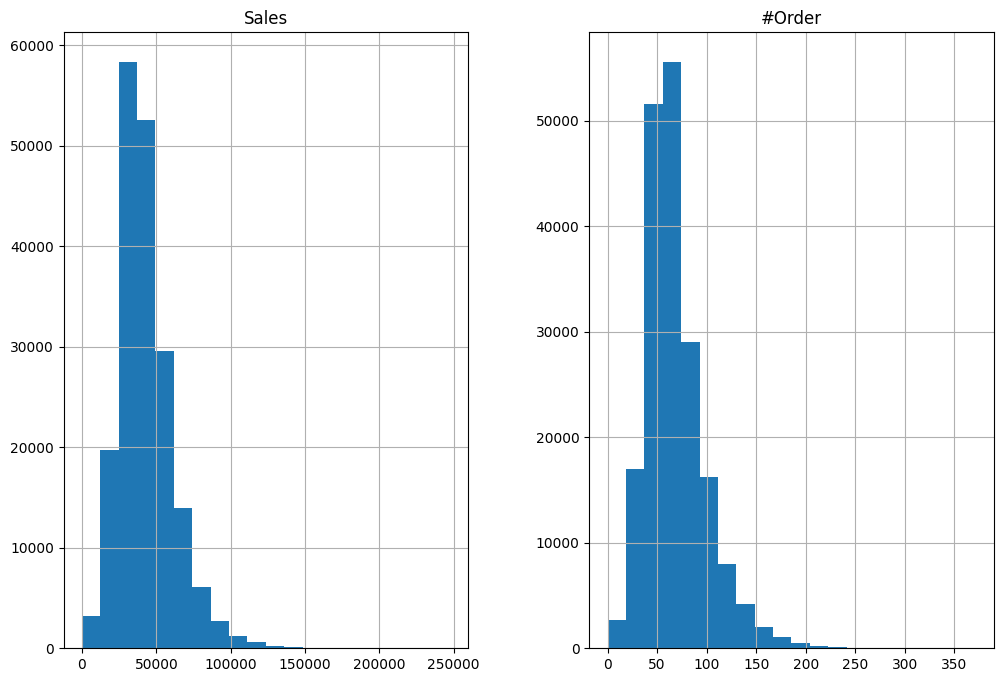

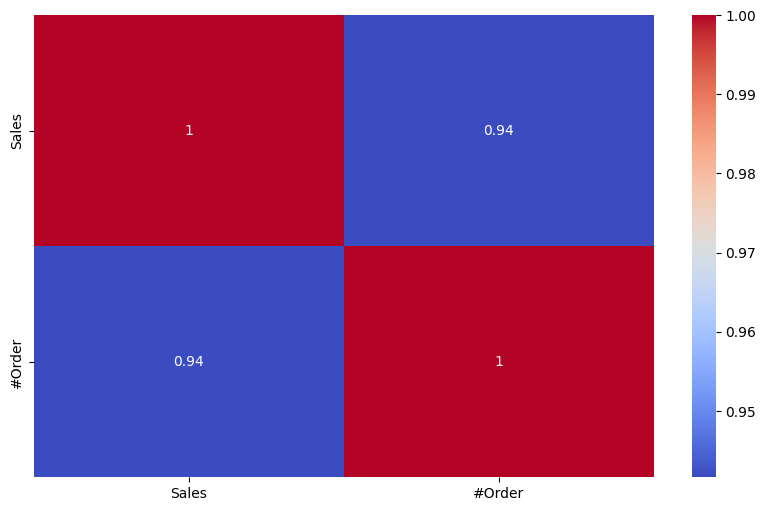

In [8]:
# Univariate Analysis - Distribution of continuous variables
df.plot(kind='box',column=['Sales','#Order'],figsize=(12, 8), subplots=True, sharey=False)
plt.show()
df.hist(column=['Sales','#Order'],figsize=(12, 8), bins=20)
plt.show()

# Bivariate Analysis - Heatmap for correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Sales','#Order']].corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()


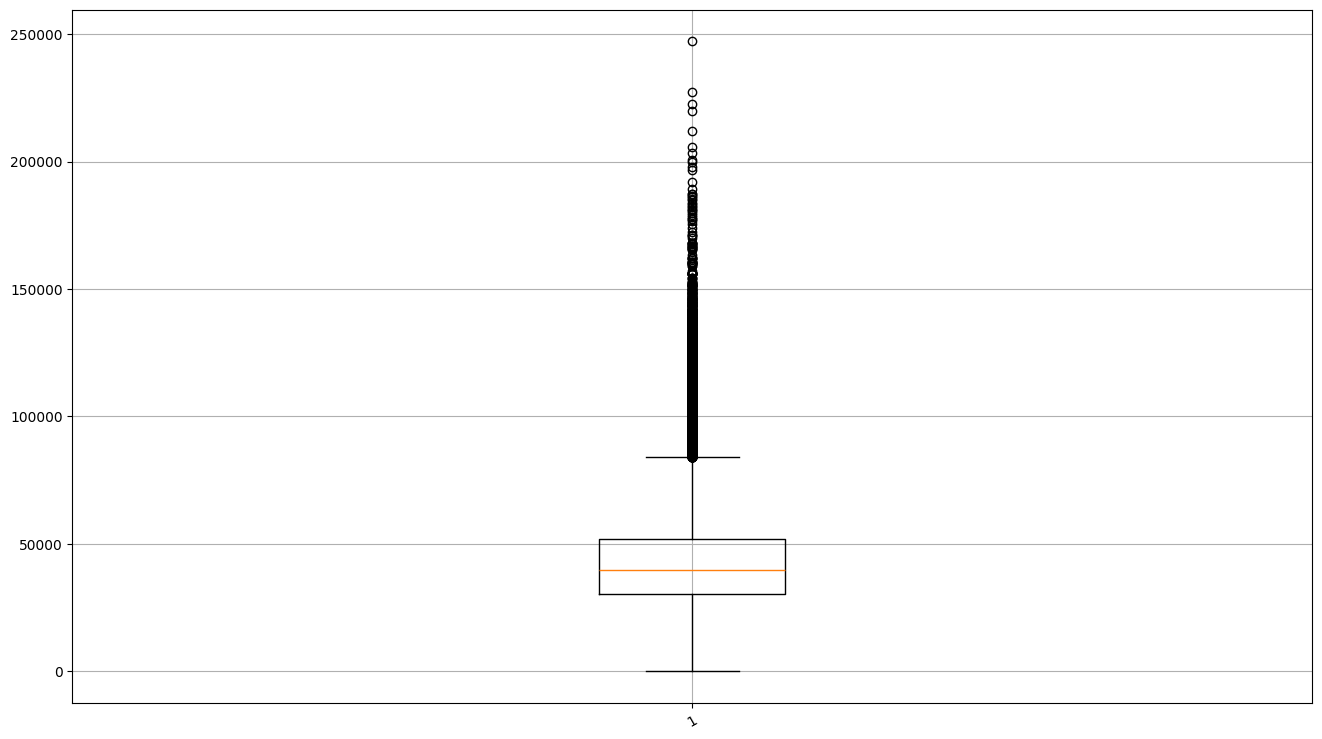

In [9]:
# plt.boxplot(df.Sales)

plt.figure(figsize=(16,9))
plt.boxplot(df.Sales)
plt.grid()
plt.xticks(rotation=30)
plt.show()

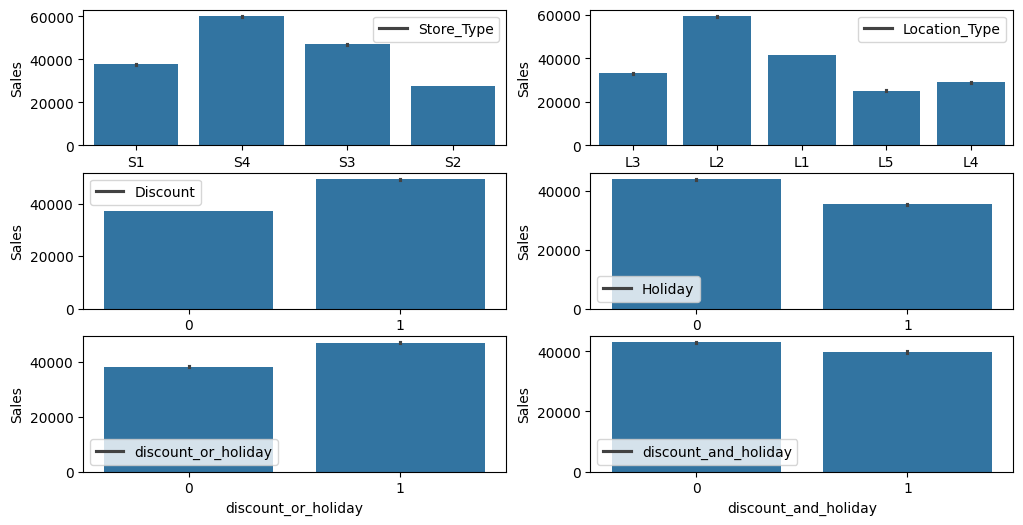

In [10]:
forlineplots = ("Store_Type","Location_Type","Discount","Holiday","discount_or_holiday","discount_and_holiday")
nrows,ncols=3,2
f, axs = plt.subplots(nrows, ncols,figsize=(12,6))
for key in range(len(forlineplots)):
    ax=sns.barplot(df,x=forlineplots[key],y="Sales",ax=axs[key//ncols][key%ncols],legend=False,linewidth=20)
    ax.legend([forlineplots[key]])
plt.show()

# --- Hypothesis Test 1: Impact of Discounts on Sales (t-test) ---

    1. Impact of Discounts on Sales:
        ◦ Hypothesis: Stores offering discounts will have significantly higher sales than stores not offering discounts.
        ◦ Test: Perform a t-test for the mean sales on days with discounts versus days without.


#####       H0: sales_discount_yes <= sales_discount_no
#####       H1: sales_discount_yes > sales_discount_no
        

# Decision Logic - Significance level at 5 % for all our Hypothesis testing

In [11]:
alpha = 0.05

In [12]:
sales_discount_yes = df[df['Discount'] == 'Yes']['Sales']
sales_discount_no = df[df['Discount'] == 'No']['Sales']

t_stat_discount, p_value_discount= stats.ttest_ind(
    sales_discount_yes, sales_discount_no, equal_var=False)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [13]:
if p_value_discount < alpha:
    print(f"Decision: Reject the Null Hypothesis at the {alpha*100}% significance level.")
    print("Conclusion: Discounts have a significant positive impact on sales.")
else:
    print(f"Decision: Fail to Reject the Null Hypothesis at the {alpha*100}% significance level.")
    print("Conclusion: There is no significant evidence that discounts impact sales.")

Decision: Fail to Reject the Null Hypothesis at the 5.0% significance level.
Conclusion: There is no significant evidence that discounts impact sales.


# --- Hypothesis Test 2: Effect of Holidays on Sales (t-test) ---

    2. Effect of Holidays on Sales:
        ◦ Hypothesis: Sales on holidays are higher compared to non-holidays.
        ◦ Test: Use a t-test or ANOVA to compare sales on holidays vs. regular days.

        H0: sales_holiday <= sales_no_holiday
        H1: sales_holiday > sales_no_holiday

In [14]:
sales_holiday = df[df['Holiday'] == 1]['Sales']
sales_no_holiday = df[df['Holiday'] == 0]['Sales']

t_stat_holiday, p_value_holiday = stats.ttest_ind(
    sales_holiday, sales_no_holiday, equal_var=False)

In [15]:
if p_value_holiday < alpha:
    print(f"Decision: Reject the Null Hypothesis at the {alpha*100}% significance level.")
    print("Conclusion: Holidays have a significant positive impact on sales.")
else:
    print(f"Decision: Fail to Reject the Null Hypothesis at the {alpha*100}% significance level.")
    print("Conclusion: There is no significant evidence that holidays impact sales.")

Decision: Reject the Null Hypothesis at the 5.0% significance level.
Conclusion: Holidays have a significant positive impact on sales.


# --- Hypothesis Test 3: Sales Differences Across Store Types (ANOVA) ---

    3. Sales Differences Across Store Types:
        ◦ Hypothesis: Different store types experience different sales volumes.
        ◦ Test: Conduct ANOVA to compare the mean sales across different store types.

        H0:s1=s2=s3=s4
        H1: Different store types experience different sales volumes
        s1!=s2!=s3<>s4

In [16]:
store_types = df['Store_Type'].unique()
sales_by_store_type = [df[df['Store_Type'] == st]['Sales'].values for st in store_types]

f_stat_anova, p_value_anova = stats.f_oneway(*sales_by_store_type)

In [17]:
if p_value_anova < alpha:
    print("\nDecision: Reject Null Hypothesis (H0)")
    print("Conclusion: There is a statistically significant difference in sales across different store types.")
else:
    print("\nDecision: Fail to Reject Null Hypothesis (H0)")
    print("Conclusion: There is no statistically significant difference in sales across different store types.")


Decision: Reject Null Hypothesis (H0)
Conclusion: There is a statistically significant difference in sales across different store types.


In [18]:
# Define the results data based on the calculated statistics
results_data = {
    'Test': ['Impact of Discounts on Sales (t-test)', 'Effect of Holidays on Sales (t-test)', 'Sales Differences Across Store Types (ANOVA)'],
    # Using the exact statistical values from the previous execution
    'Statistic': [t_stat_discount, t_stat_holiday, f_stat_anova],
    'P-value': [p_value_discount, p_value_holiday, p_value_anova]
}

# Create the DataFrame
results_df = pd.DataFrame(results_data)

# Print the header and the results table using markdown format
print("Hypothesis Testing Results:")
print(results_df.to_markdown(index=False, floatfmt=".2e"))

Hypothesis Testing Results:
| Test                                         |   Statistic |    P-value |
|:---------------------------------------------|------------:|-----------:|
| Impact of Discounts on Sales (t-test)        |  nan        | nan        |
| Effect of Holidays on Sales (t-test)         |   -6.62e+01 |   0.00e+00 |
| Sales Differences Across Store Types (ANOVA) |    3.51e+04 |   0.00e+00 |


# --- Hypothesis Test 4: Regional Sales Variability (Kruskal-Wallis Test) ---

    4. Regional Sales Variability:
        ◦ Hypothesis: There is significant variability in sales across different regions.
        ◦ Test: Kruskal-Wallis test if the data is not normally distributed or ANOVA if it is, to compare sales across regions.

        H0: Sales across different regions are same
        H1: There is significant variability in sales across different regions


In [19]:
# Prepare sales data by region
regions = df['Region_Code'].unique()
sales_by_region = [df[df['Region_Code'] == region]['Sales'].values for region in regions]

# Kruskal-Wallis H-test
h_stat_regional, p_value_regional = stats.kruskal(*sales_by_region)

In [20]:

print("Hypothesis Testing: Regional Sales Variability (Kruskal-Wallis)")
print("-" * 65)
print(f"Regions analyzed: {list(regions)}")
print(f"H-Statistic: {h_stat_regional:.4f}")
print(f"P-Value:     {p_value_regional:.4e}")

if p_value_regional < alpha:
    print("\nDecision: Reject Null Hypothesis (H0)")
    print("Conclusion: At alpha = 0.05, there is a statistically significant difference in sales across different regions.")
else:
    print("\nDecision: Fail to Reject Null Hypothesis (H0)")
    print("Conclusion: At alpha = 0.05, there is no statistically significant difference in sales across different regions.")

Hypothesis Testing: Regional Sales Variability (Kruskal-Wallis)
-----------------------------------------------------------------
Regions analyzed: ['R1', 'R4', 'R2', 'R3']
H-Statistic: 3968.0636
P-Value:     0.0000e+00

Decision: Reject Null Hypothesis (H0)
Conclusion: At alpha = 0.05, there is a statistically significant difference in sales across different regions.


# --- Test 5: Correlation between Number of Orders and Sales ---

5. Correlation between Number of Orders and Sales:
        ◦ Hypothesis: A higher number of orders correlates with higher sales.
        ◦ Test: Calculate Pearson or Spearman correlation coefficient, depending on the data distribution.
    
        H0: No linear correlation exists.
       H1: A significant linear correlation exists.

In [21]:

# --- Hypothesis Test: Correlation between Number of Orders and Sales ---

# 2. Pearson Correlation (Testing for a linear relationship)

pearson_corr, pearson_p = stats.pearsonr(df['#Order'], df['Sales'])


In [22]:
# 3. Spearman Correlation (Testing for a monotonic relationship - better for non-normal data)
# H0: No monotonic relationship exists.

# Calculate Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(df['#Order'], df['Sales'])



In [23]:
print("Hypothesis Testing: Correlation Analysis")
print("-" * 50)
print(f"Pearson Correlation:  {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")

print("\n--- Decision (alpha = 0.05) ---")
if pearson_p < alpha:
    print("Pearson: Reject Null Hypothesis. Significant linear correlation exists.")
else:
    print("Pearson: Fail to Reject Null Hypothesis.")

if spearman_p < alpha:
    print("Spearman: Reject Null Hypothesis. Significant monotonic relationship exists.")
else:
    print("Spearman: Fail to Reject Null Hypothesis.")


Hypothesis Testing: Correlation Analysis
--------------------------------------------------
Pearson Correlation:  0.9416 (p-value: 0.0000e+00)
Spearman Correlation: 0.9377 (p-value: 0.0000e+00)

--- Decision (alpha = 0.05) ---
Pearson: Reject Null Hypothesis. Significant linear correlation exists.
Spearman: Reject Null Hypothesis. Significant monotonic relationship exists.


In [24]:
# Define the results data based on the calculated statistics
results_data = {
    'Test': ['Regional Sales Variability (Kruskal-Wallis)', '#Order vs. Sales (Pearson)', 'Order_Count vs. Sales (Spearman)'],
    # Using the exact statistical values from the previous execution
    'Statistic': [h_stat_regional, pearson_corr, spearman_corr],
    'P-value': [p_value_regional, pearson_p, spearman_p]
}

# Create the DataFrame
results_df = pd.DataFrame(results_data)

# Print the header and the results table using markdown format
print("Hypothesis Testing Results:")
print(results_df.to_markdown(index=False, floatfmt=".3"))

Hypothesis Testing Results:
| Test                                        |   Statistic |   P-value |
|:--------------------------------------------|------------:|----------:|
| Regional Sales Variability (Kruskal-Wallis) |    3.97e+03 |       0.0 |
| #Order vs. Sales (Pearson)                  |    0.942    |       0.0 |
| Order_Count vs. Sales (Spearman)            |    0.938    |       0.0 |


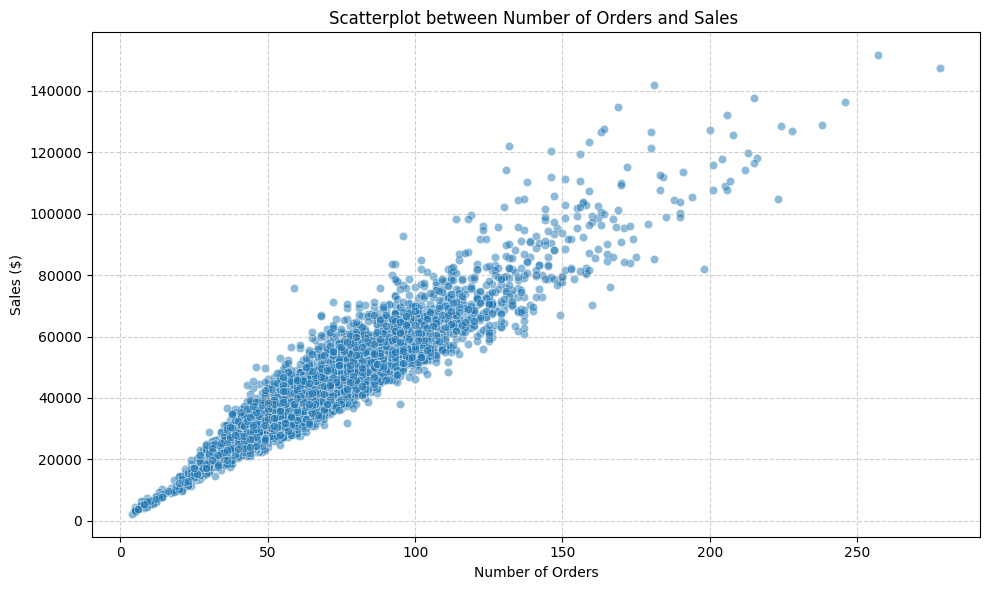

In [25]:
# --- Visualization for Correlation (Sampled data used for plotting efficiency) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='#Order', y='Sales', data=df.sample(5000, random_state=42), alpha=0.5)
plt.title('Scatterplot between Number of Orders and Sales ')
plt.xlabel('Number of Orders')
plt.ylabel('Sales ($)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()